In [307]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

# 2030 Data with surv-anlyze columns
- 생존기간
- 2023년 12월 기준 생존 여부 

In [308]:
tmp = pl.scan_csv('data/CUSTOMER_SCORE.csv')

In [309]:
tmp.collect_schema().names()

['고객ID',
 '기준년월',
 '연령대',
 '성별',
 '고객등급',
 '입출금예금',
 '기타예금',
 '비이자상품',
 '카드',
 '대출',
 '기준금리',
 '보유상품수',
 '거래기간(개월)',
 '총점수']

In [310]:
# 나이대 슬라이싱 및 생존 여부 칼럼 생성
'''
tmp = tmp.filter([
    (pl.col('연령대') == 20) |
    (pl.col('연령대') == 30) 
])
'''

tmp = tmp.with_columns([
    # 마지막 기준년월(202312)에 존재하면 0, 아니면 1
    (pl.col('기준년월').max().over('고객ID') != 202312) \
        .cast(pl.Int8) \
        .alias('surv')
])

In [311]:
tmp = tmp.group_by('고객ID').agg(
    [
        pl.col('surv').last().alias('surv'),
        pl.col('거래기간(개월)').last().alias('surv_periods'),
        (pl.col('연령대')).last().alias('age'),
        (pl.col('입출금예금')).mean().alias('account_mean'),
        (pl.col('기타예금')).mean().alias('etc_account_mean'),
        (pl.col('비이자상품')).mean().alias('nonint_mean'),
        (pl.col('카드')).mean().alias('card_mean'),
        (pl.col('대출')).mean().alias('loan_mean'),
        (pl.col('보유상품수')).mean().alias('items_mean'),
        (pl.col('보유상품수')).max().alias('items_max'),
        (pl.col('총점수')).mean().alias('totalscore_mean'),
    ]
)

In [317]:
features = ['account_mean', 'etc_account_mean','nonint_mean', 'card_mean', 'loan_mean', 'items_mean', 'items_max', 'totalscore_mean']
surv_data = tmp.collect().to_pandas()
surv_essential = surv_data[['surv', 'surv_periods']]

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [319]:
type(surv_data)

pandas.core.frame.DataFrame

In [321]:
#surv_data.to_csv('data/data_customer_credit.csv')

## 스케일러 적용
- Standard Scaler
- Robust Scaler

In [292]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
surv_data_scaled = scaler.fit_transform(surv_data[features])

In [293]:
surv_data_scaled = pd.DataFrame(surv_data_scaled)
surv_data_scaled.columns = features

surv_data_scaled.head()

,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
0,-0.018035,0.117124,-0.072811,-0.377141,-0.256386,0.740923,1.033442,-0.241193
1,-0.290008,-0.292342,-0.072811,1.383991,-0.256386,0.637493,0.046934,-0.288485
2,0.424154,1.554139,-0.072811,0.525386,-0.256386,1.706271,2.019950,-0.023825
3,1.958400,2.637461,-0.072811,2.379526,-0.256386,1.706271,1.033442,0.344391
4,-0.439871,-0.292342,-0.072811,-0.377141,-0.256386,-1.465586,-0.939574,-0.347054


In [294]:
surv_data_tmp = pd.concat([surv_essential,surv_data_scaled], axis = 1)

surv_data_tmp.head()

,surv,surv_periods,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
0,0,36,-0.018035,0.117124,-0.072811,-0.377141,-0.256386,0.740923,1.033442,-0.241193
1,0,36,-0.290008,-0.292342,-0.072811,1.383991,-0.256386,0.637493,0.046934,-0.288485
2,0,36,0.424154,1.554139,-0.072811,0.525386,-0.256386,1.706271,2.019950,-0.023825
3,0,36,1.958400,2.637461,-0.072811,2.379526,-0.256386,1.706271,1.033442,0.344391
4,0,36,-0.439871,-0.292342,-0.072811,-0.377141,-0.256386,-1.465586,-0.939574,-0.347054


In [295]:
surv_data_tmp.to_csv('data/data_complete.csv')

# 생존 EDA

In [296]:
surv_data_tmp['surv'].value_counts() # 1이 이탈

surv
0    1939785
1      38908
Name: count, dtype: int64

In [297]:
surv_data_tmp['surv_periods'].value_counts(sort=True)

surv_periods
36    1666291
1       14137
2       13109
10      12942
3       12541
4       11745
34      11602
8       11190
6       11132
12      10944
11      10843
5       10730
13      10696
9       10691
7       10616
35      10423
14      10186
15       9230
17       8726
16       8607
18       7504
22       7450
33       7242
29       7156
32       7043
28       6959
23       6778
24       6591
20       6495
30       6363
31       6269
21       6198
25       5853
19       5626
27       4961
26       3824
Name: count, dtype: int64

# kaplan - meier 생존곡선

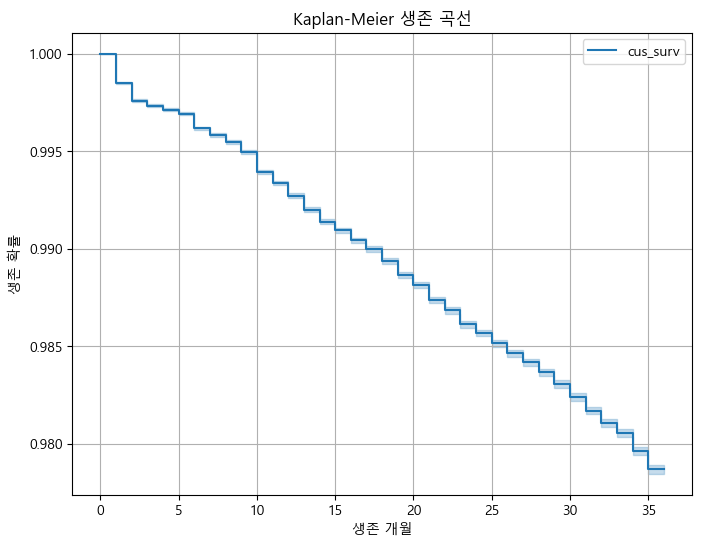

In [298]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier Fitter 모델 생성
kmf = KaplanMeierFitter()

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))
kmf.fit(durations=surv_data_tmp['surv_periods'], event_observed=surv_data_tmp['surv'], label = 'cus_surv')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 개월")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

(38908, 10) (1939785, 10)


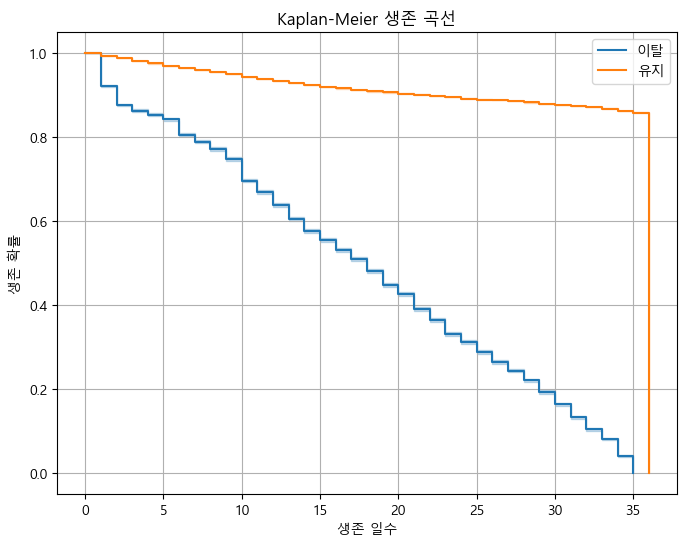

In [299]:
# 폐지된 그룹과 아닌 그룹의 케플란-마이어 결과
tmp_closed = surv_data_tmp[surv_data_tmp['surv'] == 1]  # 이탈한 사용자 분석
tmp_suv = surv_data_tmp[surv_data_tmp['surv'] == 0]     # 잔류한 이용자 분석

print(tmp_closed.shape, tmp_suv.shape)


# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))

kmf.fit(durations=tmp_closed['surv_periods'], label = '이탈')
kmf.plot_survival_function()

kmf.fit(durations=tmp_suv['surv_periods'], label = '유지')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

# Cox 비례위험모델


## 비례위험 확인 

In [300]:
surv_data_tmp.columns

Index(['surv', 'surv_periods', 'account_mean', 'etc_account_mean',
       'nonint_mean', 'card_mean', 'loan_mean', 'items_mean', 'items_max',
       'totalscore_mean'],
      dtype='object')

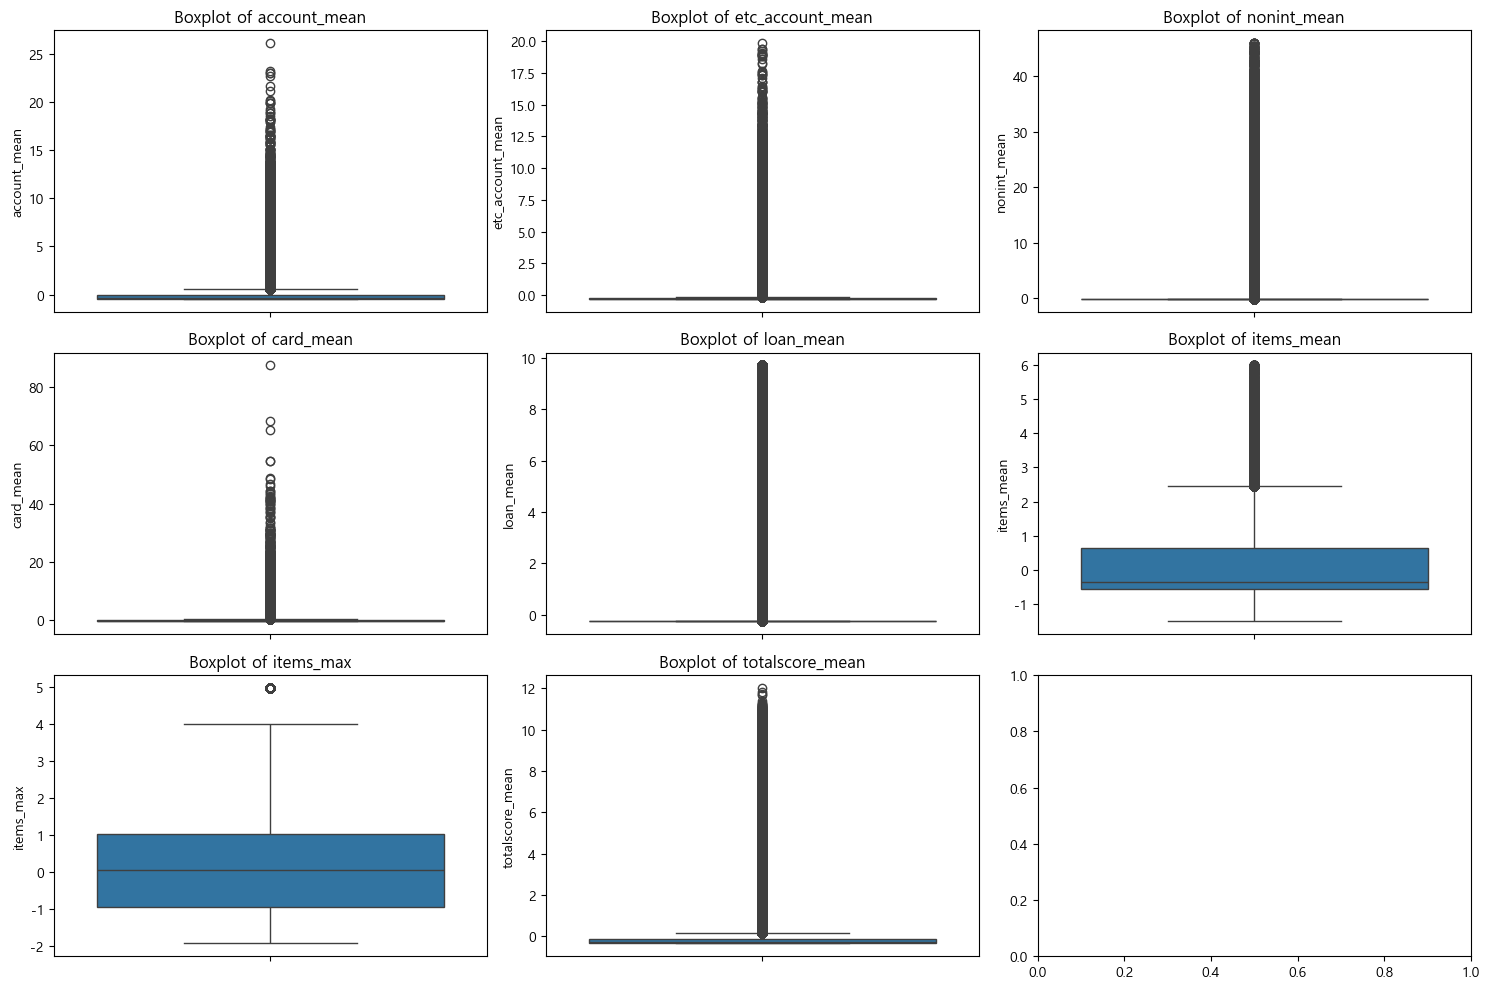

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Polars DataFrame을 pandas로 변환
#surv_data_pd = surv_data_tmp.copy()
surv_data_pd = surv_data_tmp.copy()

numeric_columns = ['account_mean', 'etc_account_mean',
       'nonint_mean', 'card_mean', 'loan_mean', 'items_mean', 'items_max',
       'totalscore_mean']

# 1. 박스플롯 그리

# 서브플롯 설정
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()  # 2D array를 1D로 변환

# 각 변수별 박스플롯
for idx, col in enumerate(numeric_columns):
    sns.boxplot(data=surv_data_pd, y=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


다중공선성 체크 (VIF):
VIF > 10인 경우 다중공선성이 있다고 판단
--------------------------------------------------
           Variable        VIF
7   totalscore_mean  14.314399
4         loan_mean  13.368880
5        items_mean   4.104458
6         items_max   3.481558
0      account_mean   1.442813
1  etc_account_mean   1.387900
3         card_mean   1.311425
2       nonint_mean   1.041070


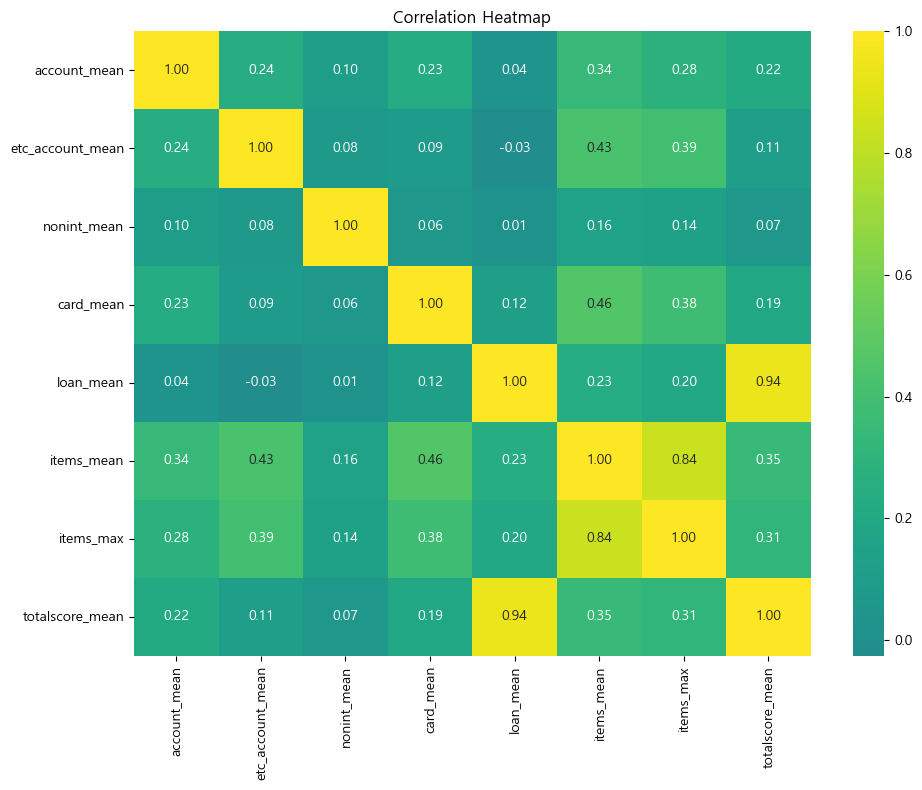


기초 통계량:
--------------------------------------------------
       account_mean  etc_account_mean   nonint_mean     card_mean  \
count  1.978693e+06      1.978693e+06  1.978693e+06  1.978693e+06   
mean  -2.790076e-16     -4.022605e-17 -7.092166e-17  7.000237e-17   
std    1.000000e+00      1.000000e+00  1.000000e+00  1.000000e+00   
min   -4.403339e-01     -2.923422e-01 -7.281139e-02 -3.771409e-01   
25%   -4.304760e-01     -2.923422e-01 -7.281139e-02 -3.771409e-01   
50%   -3.635522e-01     -2.923422e-01 -7.281139e-02 -3.771409e-01   
75%   -3.468611e-02     -2.439828e-01 -7.281139e-02 -1.136170e-01   
max    2.615804e+01      1.984211e+01  4.599923e+01  8.745556e+01   

          loan_mean    items_mean     items_max  totalscore_mean  
count  1.978693e+06  1.978693e+06  1.978693e+06     1.978693e+06  
mean   8.498928e-17 -6.336482e-16  3.896203e-17     1.853066e-16  
std    1.000000e+00  1.000000e+00  1.000000e+00     1.000000e+00  
min   -2.563857e-01 -1.500063e+00 -1.926082e+00   

In [302]:
# 2. 다중공선성 체크 (VIF)
# 수치형 변수들의 VIF 계산
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i)
                       for i in range(df[features].shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# VIF 계산 및 출력
print("\n다중공선성 체크 (VIF):")
print("VIF > 10인 경우 다중공선성이 있다고 판단")
print("-" * 50)
vif_result = calculate_vif(surv_data_pd, numeric_columns)
print(vif_result)

# 3. 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(surv_data_pd[numeric_columns].corr(), 
            annot=True,  # 상관계수 표시
            cmap='viridis',  # 색상맵
            center=0,  # 중앙값 (0) 기준
            fmt='.2f')  # 소수점 2자리까지 표시
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4. 기초 통계량 출력
print("\n기초 통계량:")
print("-" * 50)
print(surv_data_pd[numeric_columns].describe())

## Cox 분석 

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 1.97869e+06 total observations, 1.93978e+06 right-censored observations>
             duration col = 'surv_periods'
                event col = 'surv'
      baseline estimation = breslow
   number of observations = 1.97869e+06
number of events observed = 38908
   partial log-likelihood = -796663.63
         time fit was run = 2025-03-13 08:00:41 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
age               0.00      1.00      0.00            0.00            0.00                1.00                1.00
account_mean      0.00      1.00      0.00            0.00            0.00                1.00                1.00
etc_account_mean  0.00      1.00      0.00            0.00            0.00                1.00                1.00
nonint_mean       0.00      1.00      0.00            0.00            0.00                1.00                1.00
card_mean         0.00      1.00      0.00            0.00            0.00                1.00                1.00
loan_mean         0.00      1.00      0.00            0.00            0.00                1.00                1.00
items_mean       -0.11      0.90      0.02           -0.14           -0.08                0.87                0.92
items_max         0.11      1.12      0.01            0.08            0.13                1.09                1.14
totalscore_mean  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                  cmp to       z      p  -log2(p)
covariate                                        
age                 0.00    2.65   0.01      6.97
account_mean        0.00  240.55 <0.005       inf
etc_account_mean    0.00   91.09 <0.005       inf
nonint_mean         0.00  105.95 <0.005       inf
card_mean           0.00   33.58 <0.005    818.97
loan_mean           0.00  375.20 <0.005       inf
items_mean          0.00   -6.89 <0.005     37.42
items_max           0.00    8.23 <0.005     52.22
totalscore_mean     0.00 -312.30 <0.005       inf
---
Concordance = 0.92
Partial AIC = 1593345.26
log-likelihood ratio test = -472157.35 on 9 df
-log2(p) of ll-ratio test = -0.00

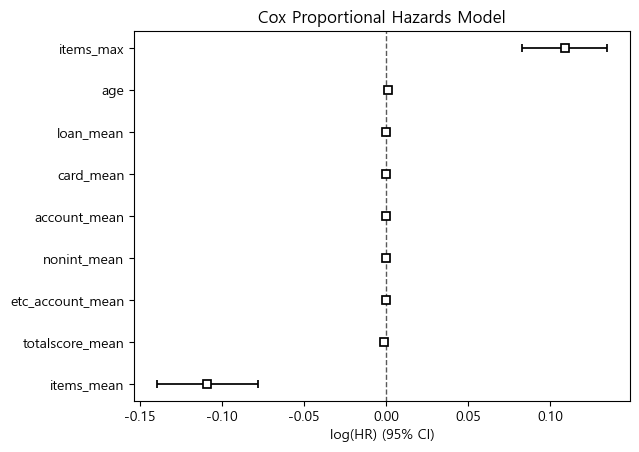

In [303]:
# Polars DataFrame을 pandas DataFrame으로 변환
surv_data_pd = surv_data.to_pandas()

# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
# Polars DataFrame을 pandas DataFrame으로 변환한 데이터 사용
cph.fit(surv_data_pd.drop(columns=['고객ID']), 
        duration_col='surv_periods', 
        event_col='surv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 1.97869e+06 total observations, 1.93978e+06 right-censored observations>
             duration col = 'surv_periods'
                event col = 'surv'
      baseline estimation = breslow
   number of observations = 1.97869e+06
number of events observed = 38908
   partial log-likelihood = -803375.57
         time fit was run = 2025-03-13 08:00:54 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
account_mean      0.85      2.33      0.00            0.84            0.85                2.32                2.35
etc_account_mean  0.60      1.82      0.01            0.58            0.61                1.79                1.84
nonint_mean       0.20      1.22      0.00            0.20            0.20                1.22                1.23
card_mean         0.10      1.10      0.00            0.09            0.11                1.10                1.11
loan_mean         5.78    322.43      0.01            5.75            5.80              313.63              331.48
totalscore_mean  -5.27      0.01      0.02           -5.30           -5.24                0.00                0.01

                  cmp to       z      p  -log2(p)
covariate                                        
account_mean        0.00  265.82 <0.005       inf
etc_account_mean    0.00  104.13 <0.005       inf
nonint_mean         0.00  101.02 <0.005       inf
card_mean           0.00   33.08 <0.005    794.61
loan_mean           0.00  408.96 <0.005       inf
totalscore_mean     0.00 -332.22 <0.005       inf
---
Concordance = 0.93
Partial AIC = 1606763.13
log-likelihood ratio test = -485581.22 on 6 df
-log2(p) of ll-ratio test = -0.00

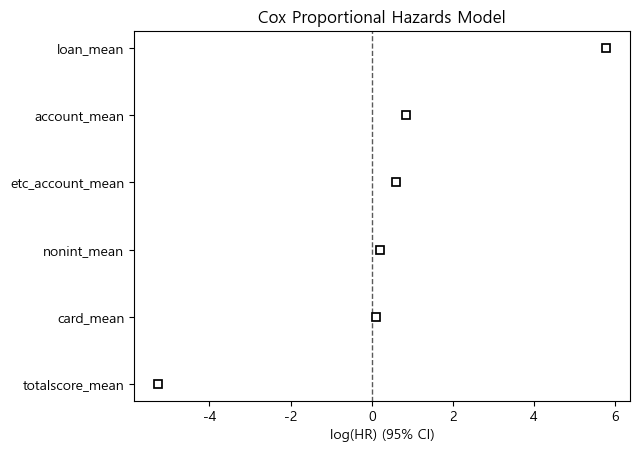

In [304]:
from lifelines import CoxPHFitter

# Polars DataFrame을 pandas DataFrame으로 변환
surv_data_tmp_2 = surv_data_tmp.drop(columns=['items_max', 'items_mean'])

# 모델 학습
# Polars DataFrame을 pandas DataFrame으로 변환한 데이터 사용
cph.fit(surv_data_tmp_2, 
        duration_col='surv_periods', 
        event_col='surv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

In [305]:
surv_data_pd.sample(30)

,고객ID,surv,surv_periods,age,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
1288909,7848193701,0,36,60,1.341935e+06,0.000000e+00,0.0,0.000000,0.000000e+00,1.000000,1,123.655914
1311232,5988765122,0,36,60,5.935484e+05,0.000000e+00,0.0,4193.548387,0.000000e+00,0.967742,2,69.234409
1104133,2857603164,0,28,30,1.428571e+04,0.000000e+00,0.0,0.000000,2.946429e+06,1.035714,2,943.226488
1567933,6955114925,0,36,30,1.000000e+05,0.000000e+00,0.0,0.000000,0.000000e+00,1.000000,1,30.580645
982313,5444081052,0,36,50,1.206774e+07,0.000000e+00,0.0,100645.161290,3.525806e+06,2.290323,3,2593.112097
102027,9053264660,0,36,60,6.700000e+06,0.000000e+00,0.0,217096.774194,0.000000e+00,1.419355,2,573.632258
455643,4415798441,0,36,10,0.000000e+00,3.000000e+05,0.0,0.000000,0.000000e+00,1.000000,1,34.580645
80602,7895826466,0,36,60,4.770968e+06,0.000000e+00,0.0,0.000000,0.000000e+00,1.000000,1,412.258065
962441,5610134129,0,36,40,3.903226e+05,8.709677e+04,0.0,0.000000,3.767742e+07,2.354839,3,15994.474462
1355022,8337931112,0,36,50,1.286000e+07,4.442400e+07,33240000.0,495600.000000,0.000000e+00,4.560000,5,4748.410667


# Save Data

In [306]:
# 데이터로 저장
#surv_data_pd.to_csv('data/surv_data_2030_mean.csv')

dfsf